# Titanic Dataset - Random Forest

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ReadIn the training data
titanic_train = pd.read_csv("titanic_train.csv")
print (titanic_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## Variable Notes

>pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

>age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

>sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancÃ©s were ignored)

>parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [3]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Separate out the target/ label from the dataset

In [5]:
print(f'All column names: {titanic_train.columns}')
X_train = titanic_train.copy()
y_train = X_train.pop('Survived')
print(f'Training data column names: {X_train.columns}')
print(f'Training label: {y_train.name}')

All column names: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Training data column names: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Training label: Survived


## Helper Functions

In [6]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    # print (big_string)
    return np.nan

def replace_titles(x):
    title=x['salut']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

## Data Preprocessing - Training Data

In [7]:
# Split Name and extract the salutation

X_train['salut'] = X_train['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
print("Unique values from salut - training dataset:\n", X_train['salut'].unique(), "\n")

print ("salut Before:")
print (X_train['salut'].value_counts(), "\n")

# X_train.drop(['firstname', 'last_name', 'lastname', 'lastname1'], axis=1, inplace=True)
print (X_train.columns, "\n")

X_train['salut']=X_train.apply(replace_titles, axis=1)
print ("salut After:")
print (X_train['salut'].value_counts())

Age_salut = pd.crosstab(X_train.Age, X_train.salut)
Age_salut.tail(10)

Unique values from salut - training dataset:
 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer'] 

salut Before:
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
the Countess      1
Lady              1
Ms                1
Jonkheer          1
Don               1
Sir               1
Mme               1
Capt              1
Name: salut, dtype: int64 

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'salut'],
      dtype='object') 

salut After:
Mr        531
Miss      185
Mrs       135
Master     40
Name: salut, dtype: int64


salut,Master,Miss,Mr,Mrs
Age,,,,
62.0,0,0,3,1
63.0,0,1,0,1
64.0,0,0,2,0
65.0,0,0,3,0
66.0,0,0,1,0
70.0,0,0,2,0
70.5,0,0,1,0
71.0,0,0,2,0
74.0,0,0,1,0


## Imputing data to fill in the missing values

In [8]:
# Imputing Age - We are using the 'salut' feature to group the respondent to impute the age
print ("Null values for Age before imputation: ", X_train['Age'].isnull().sum())
X_train['Age'] = X_train.groupby('salut').Age.transform(lambda x: x.fillna(x.mean()))
print ("Null values for Age after imputation: ", X_train['Age'].isnull().sum())

Null values for Age before imputation:  177
Null values for Age after imputation:  0


In [9]:
# Imputing Cabin - This cannot be imputed as there is no logic and hence we fill the NAs with 'Null' string
print("Null values for Cabin before imputation: ", X_train['Cabin'].isnull().sum())

print("Value Counts of Cabin - Before")
print (X_train['Cabin'].value_counts(dropna = False))

X_train['Cabin'] = X_train['Cabin'].fillna('Null')

print("Value Counts of Cabin - After")
print (X_train['Cabin'].value_counts(dropna = False))

Null values for Cabin before imputation:  687
Value Counts of Cabin - Before
NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
F2               3
              ... 
C47              1
A34              1
A6               1
C103             1
C54              1
Name: Cabin, Length: 148, dtype: int64
Value Counts of Cabin - After
Null           687
G6               4
B96 B98          4
C23 C25 C27      4
F33              3
              ... 
B19              1
B3               1
F G63            1
B101             1
F E69            1
Name: Cabin, Length: 148, dtype: int64


In [10]:
# Imputing the whole dataset just in case there are any furhter missing values
X_train = X_train.fillna(method='ffill').fillna(method='bfill')
print("Null values after imputation: ")
print(X_train.isnull().sum())

Null values after imputation: 
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
salut          0
dtype: int64


## Feature Engineering

In [11]:
# Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Null']
X_train['Deck']=X_train['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

X_train['Deck'].value_counts()

Null    687
C        59
B        47
D        33
E        33
A        15
F        12
G         4
T         1
Name: Deck, dtype: int64

In [12]:
# Family Size and Fare per Passenger
X_train['FamilySize'] = X_train['SibSp'] + X_train['Parch'] + 1
# X_train['FarePerPassenger'] = X_train['Fare']/(X_train['FamilySize'])

print(X_train['FamilySize'].value_counts())
# print()
# print(X_train['FarePerPassenger'].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [13]:
# X_train.to_csv("Titanic_Train_Processed.csv", index = False)

## Converting Categorical and String features into Numeric

In [14]:
# Drop features which are unique across respondents as they are not useful
X_train.drop(['Name', 'PassengerId'], axis=1, inplace=True)

# One Hot Encoding - To convert categorical to binary data
X_train_dummies = pd.get_dummies(X_train, columns=['Pclass', 'Sex', 'Cabin', 'Embarked', 'salut', 'Ticket', 'Deck'])

print ("Shape of training dataset after One Hot Encoding: ", X_train_dummies.shape)
print (X_train_dummies.head())

Shape of training dataset after One Hot Encoding:  (891, 855)
    Age  SibSp  Parch     Fare  FamilySize  Pclass_1  Pclass_2  Pclass_3  \
0  22.0      1      0   7.2500           2         0         0         1   
1  38.0      1      0  71.2833           2         1         0         0   
2  26.0      0      0   7.9250           1         0         0         1   
3  35.0      1      0  53.1000           2         1         0         0   
4  35.0      0      0   8.0500           1         0         0         1   

   Sex_female  Sex_male  ...  Ticket_WE/P 5735  Deck_A  Deck_B  Deck_C  \
0           0         1  ...                 0       0       0       0   
1           1         0  ...                 0       0       0       1   
2           1         0  ...                 0       0       0       0   
3           1         0  ...                 0       0       0       1   
4           0         1  ...                 0       0       0       0   

   Deck_D  Deck_E  Deck_F  Deck_G  D

## Test Data - ReadIn, Preprocess, Imputing, Feature Engineering and One Hot Encoding

In [15]:
# ReadIn the test data

titanic_test = pd.read_csv("titanic_test.csv")

In [16]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [17]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [18]:
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [19]:
X_test = titanic_test.copy()

# Split Name and extract the salutation
X_test['salut'] = X_test['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
print("Unique values from salut - test dataset:\n", X_test['salut'].unique())

print ("salut Before:")
print (X_test['salut'].value_counts())

print (X_test.columns)

X_test['salut']=X_test.apply(replace_titles, axis=1)

print ("salut After:")
print (X_test['salut'].value_counts())

Age_salut_test = pd.crosstab(X_test.Age, X_test.salut)
print(Age_salut_test.head(6))
print(Age_salut_test.tail(6))

Unique values from salut - test dataset:
 ['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
salut Before:
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Ms          1
Dona        1
Dr          1
Name: salut, dtype: int64
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'salut'],
      dtype='object')
salut After:
Mr        244
Miss       79
Mrs        74
Master     21
Name: salut, dtype: int64
salut  Master  Miss  Mr  Mrs
Age                         
0.17        0     1   0    0
0.33        1     0   0    0
0.75        1     0   0    0
0.83        1     0   0    0
0.92        0     1   0    0
1.00        0     3   0    0
salut  Master  Miss  Mr  Mrs
Age                         
61.0        0     0   2    0
62.0        0     0   1    0
63.0        0     0   1    1
64.0        0     0   1    2
67.0        0     0   1    0
76.0        0     0   0    1


In [20]:
# Imputing missing values - Test Data
print ("Null values for Age before imputation: ", X_test['Age'].isnull().sum())
X_test['Age'] = X_test.groupby('salut').Age.transform(lambda x: x.fillna(x.mean()))
print ("Null values for Age after imputation: ", X_test['Age'].isnull().sum(), "\n")

print ("Null values for Fare before imputation: ", X_test['Fare'].isnull().sum())
X_test['Fare'] = X_test.groupby('Pclass').Fare.transform(lambda x: x.fillna(x.median()))
print ("Null values for Fare after imputation: ", X_test['Fare'].isnull().sum(), "\n")

print("Null values for Cabin before imputation: ", X_test['Cabin'].isnull().sum())
X_test['Cabin'] = X_test['Cabin'].fillna('Null')
print("Null values for Cabin after imputation: ", X_test['Cabin'].isnull().sum(), "\n")

# Imputing the whole dataset just in case there are any furhter missing values
X_test = X_test.fillna(method='ffill').fillna(method='bfill')

print("Null values after imputation: ")
print(X_test.isnull().sum())

Null values for Age before imputation:  86
Null values for Age after imputation:  0 

Null values for Fare before imputation:  1
Null values for Fare after imputation:  0 

Null values for Cabin before imputation:  327
Null values for Cabin after imputation:  0 

Null values after imputation: 
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
salut          0
dtype: int64


In [21]:
## Feature Engineering
# Deck
X_test['Deck']=X_test['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
print(X_test['Deck'].value_counts(), "\n")

# Family Size and Fare per Passenger
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1
# X_test['FarePerPassenger'] = X_test['Fare']/(X_test['FamilySize'] + 1)

print(X_test['FamilySize'].value_counts(), "\n")
# print()
# print(X_test['FarePerPassenger'].value_counts(), "\n")

Null    327
C        35
B        18
D        13
E        11
A         7
F         6
G         1
Name: Deck, dtype: int64 

1     253
2      74
3      57
4      14
5       7
11      4
7       4
6       3
8       2
Name: FamilySize, dtype: int64 



In [22]:
## Converting Categorical and String features into Numeric

# Drop features which are unique across respondents as they are not useful
X_test.drop(['PassengerId'], axis=1, inplace=True)

# One Hot Encoding - To convert categorical to binary data
X_test_dummies = pd.get_dummies(X_test, columns=['Pclass', 'Sex', 'Cabin', 'Embarked', 'salut', 'Ticket', 'Deck'])
print ("Shape of test dataset after One Hot Encoding: ", X_test_dummies.shape)
print (X_test_dummies.head())

Shape of test dataset after One Hot Encoding:  (418, 466)
                                           Name   Age  SibSp  Parch     Fare  \
0                              Kelly, Mr. James  34.5      0      0   7.8292   
1              Wilkes, Mrs. James (Ellen Needs)  47.0      1      0   7.0000   
2                     Myles, Mr. Thomas Francis  62.0      0      0   9.6875   
3                              Wirz, Mr. Albert  27.0      0      0   8.6625   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  22.0      1      1  12.2875   

   FamilySize  Pclass_1  Pclass_2  Pclass_3  Sex_female  ...  \
0           1         0         0         1           0  ...   
1           2         0         0         1           1  ...   
2           1         0         1         0           0  ...   
3           1         0         0         1           0  ...   
4           3         0         0         1           1  ...   

   Ticket_W./C. 6608  Ticket_W.E.P. 5734  Deck_A  Deck_B  Deck_C  Deck_D  \


In [23]:
print ("Shape of training dataset after One Hot Encoding: ", X_train_dummies.shape)
print ("Shape of test dataset after One Hot Encoding: ", X_test_dummies.shape)

Shape of training dataset after One Hot Encoding:  (891, 855)
Shape of test dataset after One Hot Encoding:  (418, 466)


In [24]:
# Align the Train and Test datset for One Hot Encoding 
X_train_final, X_test_final = X_train_dummies.align(X_test_dummies, join='left', axis=1)
print (X_train_final.shape)
print (X_test_final.shape)

for col in (col for col in X_test_final.columns if X_test_final[col].isnull().any()):
    X_test_final[col] = 0

print(X_test_final.isnull().sum())

(891, 855)
(418, 855)
Age           0
SibSp         0
Parch         0
Fare          0
FamilySize    0
             ..
Deck_E        0
Deck_F        0
Deck_G        0
Deck_Null     0
Deck_T        0
Length: 855, dtype: int64


## Model Training

### Scaling the data

Do note that Random Forest doen't necessarily need scaling

In [25]:
X_train_final_description = X_train_final.describe().T
X_test_final_description = X_test_final.describe().T

X_train_final_description.to_csv("X_train_final_description.csv")
X_test_final_description.to_csv("X_test_final_description.csv")

In [26]:
from sklearn import preprocessing

standard_scaler = preprocessing.StandardScaler()
X_train_standard_scaled = standard_scaler.fit_transform(X_train_final)
# X_train_standard_scaled.mean(axis=0)
X_test_standard_scaled = standard_scaler.fit_transform(X_test_final)

In [27]:
# split the data into train and evaluation data
from sklearn.model_selection import train_test_split

# X, val_X, y, val_y = train_test_split(X_train_final, y_train, train_size=0.7, test_size=0.3, random_state=123, stratify=y_train)

# Applying scaled data
X, val_X, y, val_y = train_test_split(X_train_standard_scaled, y_train, train_size=0.7, test_size=0.3, random_state=123, stratify=y_train)

print (X.shape)
print (val_X.shape)
print('All:', np.bincount(y_train) / float(len(y_train)) * 100.0)
print('Training:', np.bincount(y) / float(len(y)) * 100.0)
print('Test:', np.bincount(val_y) / float(len(val_y)) * 100.0)

(623, 855)
(268, 855)
All: [61.61616162 38.38383838]
Training: [61.63723917 38.36276083]
Test: [61.56716418 38.43283582]


### Random Forest

In [28]:
# Model using Random Forest
from sklearn.ensemble import RandomForestClassifier

# rfc = RandomForestClassifier(n_estimators=20, min_samples_split=2, random_state=41, min_impurity_decrease=0.0, verbose=0, max_leaf_nodes=90000000)
model_random_forest = RandomForestClassifier(random_state=41)
# rfc_model = mdlrfc.fit(X, y)
model_random_forest.fit(X, y)

print("Model Parameters:")
print(model_random_forest.get_params(), "\n")

predictions = model_random_forest.predict(val_X)
predict_proba = model_random_forest.predict_proba(val_X)

print ("Count for validation data - actual: ", np.bincount(val_y))
print ("Count for validation data - prediction: ", np.bincount(predictions), "\n")

Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 41, 'verbose': 0, 'warm_start': False} 

Count for validation data - actual:  [165 103]
Count for validation data - prediction:  [179  89] 



### Model Evaluation

In [29]:
# Score
print ("Score for training data - Random Forest: ", model_random_forest.score(X, y))
score_val_dataset = model_random_forest.score(val_X, val_y)
print ("Score for validation data - Random Forest: ", score_val_dataset, "\n")

print("Predictions: ", predictions[0:6], "\n")
print("Prediction Probabilities:\n", predict_proba[0:6])

Score for training data - Random Forest:  1.0
Score for validation data - Random Forest:  0.835820895522388 

Predictions:  [0 1 0 0 0 0] 

Prediction Probabilities:
 [[0.9  0.1 ]
 [0.   1.  ]
 [0.9  0.1 ]
 [0.97 0.03]
 [0.99 0.01]
 [0.74 0.26]]


In [30]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score, confusion_matrix, roc_curve

print ("f1_score for validation data - Random Forest: ", f1_score(val_y, model_random_forest.predict(val_X)))
print ("f1_score (average=None) for validation data - Random Forest: ", f1_score(val_y, model_random_forest.predict(val_X), average=None), "\n")

print ("precision_recall_fscore for validation data - Random Forest: ", precision_recall_fscore_support(val_y, model_random_forest.predict(val_X)), "\n")

print("Accuracy for model Random Forest: %.2f" % (accuracy_score(val_y, model_random_forest.predict(val_X)) * 100))

f1_score for validation data - Random Forest:  0.7708333333333335
f1_score (average=None) for validation data - Random Forest:  [0.87209302 0.77083333] 

precision_recall_fscore for validation data - Random Forest:  (array([0.83798883, 0.83146067]), array([0.90909091, 0.7184466 ]), array([0.87209302, 0.77083333]), array([165, 103], dtype=int64)) 

Accuracy for model Random Forest: 83.58


### Model Selection

In [31]:
# Applying cross validation on the enire training data
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, ShuffleSplit

# scores = cross_val_score(model_logistic_regression, X_train_final, y_train)
scores = cross_val_score(model_random_forest, X_train_standard_scaled, y_train)
print("\nScore for training data with default CV: ", scores)
print(np.mean(scores))

scores = cross_val_score(model_random_forest, X_train_standard_scaled, y_train, cv=3)
print("\nScore for training data with CV=3: ", scores)
print(np.mean(scores))


Score for training data with default CV:  [0.84357542 0.80337079 0.86516854 0.80898876 0.83707865]
0.8316364321134895

Score for training data with CV=3:  [0.81144781 0.83164983 0.83164983]
0.8249158249158249


In [32]:
# Applying cross validation by splitting the training data into training data and validation data
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, ShuffleSplit

scores = cross_val_score(model_random_forest, X, y)
print("Score for training data with default CV: ", scores)
print("Mean Score: ", np.mean(scores), "\n")

scores = cross_val_score(model_random_forest, X, y, cv=3)
print("Score for training data with CV=3: ", scores)
print("Mean Score: ", np.mean(scores), "\n")

scores = cross_val_score(model_random_forest, val_X, val_y, cv=3)
print("Score for validation data with CV=3: ", scores)
print("Mean Score: ", np.mean(scores))

Score for training data with default CV:  [0.864      0.832      0.8        0.85483871 0.84677419]
Mean Score:  0.8395225806451613 

Score for training data with CV=3:  [0.85096154 0.82211538 0.79710145]
Mean Score:  0.8233927907840951 

Score for validation data with CV=3:  [0.81111111 0.78651685 0.79775281]
Mean Score:  0.7984602580108198


In [33]:
cv = StratifiedKFold(n_splits=4)
scores = cross_val_score(model_random_forest, val_X, val_y, cv=cv)
print("Score for validation data with StartifiedKFold, CV=5: ", scores)
print("Mean Score: ", np.mean(scores))

Score for validation data with StartifiedKFold, CV=5:  [0.85074627 0.74626866 0.79104478 0.79104478]
Mean Score:  0.794776119402985


### GridSearch

In [34]:
from sklearn.model_selection import GridSearchCV
# param_grid = {'random_state': [41, 103, 141], 'n_estimators': [10, 20, 30], 'min_samples_split': [2, 3, 4, 5],'max_leaf_nodes':[90, 900, 9000, None] }
param_grid = {'random_state': [41], 'n_estimators': [10, 20, 30], 'min_samples_split': [2, 3, 4, 5],'max_leaf_nodes':[90, 900, 9000, None] }

model_random_forest_grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv, verbose=3)
model_random_forest_grid.fit(X, y)

results_grid = model_random_forest_grid.cv_results_

print ("Parameters: ", model_random_forest_grid.get_params)

print("\nGridSearchCV best score - Random Forest: ", model_random_forest_grid.best_score_)
print("\nGridSearchCV best params - Random Forest: ", model_random_forest_grid.best_params_)
print("\nGridSearchCV best estimator - Random Forest: ", model_random_forest_grid.best_estimator_)

print ("\nGridSearchCV Score for validation data - Random Forest: ", model_random_forest_grid.score(val_X, val_y))

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41, score=0.827, total=   0.0s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41, score=0.763, total=   0.0s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41, score=0.846, total=   0.0s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41, score=0.839, total=   0.0s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41, score=0.846, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41, score=0.776, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41, score=0.833, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41, score=0.819, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=30, random_state=41, score=0.865, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=30, random_

[CV]  max_leaf_nodes=900, min_samples_split=2, n_estimators=10, random_state=41, score=0.763, total=   0.0s
[CV] max_leaf_nodes=900, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=2, n_estimators=10, random_state=41, score=0.846, total=   0.0s
[CV] max_leaf_nodes=900, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=2, n_estimators=10, random_state=41, score=0.826, total=   0.0s
[CV] max_leaf_nodes=900, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=2, n_estimators=20, random_state=41, score=0.846, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=2, n_estimators=20, random_state=41, score=0.769, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=2, n_estimators=

[CV]  max_leaf_nodes=900, min_samples_split=5, n_estimators=30, random_state=41, score=0.788, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=5, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=5, n_estimators=30, random_state=41, score=0.846, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=5, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=5, n_estimators=30, random_state=41, score=0.806, total=   0.1s
[CV] max_leaf_nodes=9000, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=2, n_estimators=10, random_state=41, score=0.840, total=   0.0s
[CV] max_leaf_nodes=9000, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=2, n_estimators=10, random_state=41, score=0.763, total=   0.0s
[CV] max_leaf_nodes=9000, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=2, n_estim

[CV]  max_leaf_nodes=9000, min_samples_split=5, n_estimators=20, random_state=41, score=0.808, total=   0.1s
[CV] max_leaf_nodes=9000, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=5, n_estimators=20, random_state=41, score=0.833, total=   0.1s
[CV] max_leaf_nodes=9000, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=5, n_estimators=20, random_state=41, score=0.826, total=   0.1s
[CV] max_leaf_nodes=9000, min_samples_split=5, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=5, n_estimators=30, random_state=41, score=0.872, total=   0.1s
[CV] max_leaf_nodes=9000, min_samples_split=5, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=5, n_estimators=30, random_state=41, score=0.788, total=   0.1s
[CV] max_leaf_nodes=9000, min_samples_split=5, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=5, n_

[CV]  max_leaf_nodes=None, min_samples_split=5, n_estimators=10, random_state=41, score=0.795, total=   0.1s
[CV] max_leaf_nodes=None, min_samples_split=5, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=5, n_estimators=10, random_state=41, score=0.813, total=   0.1s
[CV] max_leaf_nodes=None, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=5, n_estimators=20, random_state=41, score=0.853, total=   0.2s
[CV] max_leaf_nodes=None, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=5, n_estimators=20, random_state=41, score=0.788, total=   0.2s
[CV] max_leaf_nodes=None, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=5, n_estimators=20, random_state=41, score=0.821, total=   0.2s
[CV] max_leaf_nodes=None, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=5, n_

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   17.9s finished


In [35]:
results_grid

{'mean_fit_time': array([0.03473455, 0.06822568, 0.1079492 , 0.06046706, 0.07945913,
        0.09745294, 0.04223156, 0.06696528, 0.09620535, 0.0474878 ,
        0.07420766, 0.11569893, 0.04423904, 0.08570528, 0.12517399,
        0.04623407, 0.10269016, 0.11744887, 0.04123998, 0.09694952,
        0.12942702, 0.04122692, 0.08070928, 0.11293966, 0.04497397,
        0.0847106 , 0.1284408 , 0.04799134, 0.08070183, 0.11894202,
        0.04597414, 0.08670169, 0.12018186, 0.05596864, 0.10444576,
        0.12392855, 0.04847306, 0.07596743, 0.1251775 , 0.0429796 ,
        0.07620645, 0.14516646, 0.03773552, 0.11043775, 0.17365122,
        0.07146126, 0.15591127, 0.13817132]),
 'std_fit_time': array([0.00192712, 0.00370517, 0.00814385, 0.01118528, 0.00319222,
        0.00349044, 0.00217927, 0.00578252, 0.00516726, 0.0120461 ,
        0.00390671, 0.02683173, 0.00042383, 0.00249415, 0.00851641,
        0.00286895, 0.0196155 , 0.01063948, 0.00178092, 0.013758  ,
        0.02359409, 0.00108933, 0.007

In [36]:
print("Model Parameters:")
print(model_random_forest_grid.get_params(), "\n")

predictions_grid = model_random_forest_grid.predict(val_X)
predict_proba_grid = model_random_forest_grid.predict_proba(val_X)

print ("Count for validation data - actual: ", np.bincount(val_y))
print ("Count for validation data - prediction-grid: ", np.bincount(predictions_grid), "\n")

Model Parameters:
{'cv': StratifiedKFold(n_splits=4, random_state=None, shuffle=False), 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_d

In [37]:
# Score
print ("Score for training data - Random Forest: ", model_random_forest_grid.score(X, y))
score_grid_val_dataset = model_random_forest_grid.score(val_X, val_y)
print ("Score for validation data - Random Forest: ", score_grid_val_dataset, "\n")

print("Predictions grid: ", predictions_grid[0:6], "\n")
print("Prediction Probabilities grid:\n", predict_proba_grid[0:6])

Score for training data - Random Forest:  0.9229534510433387
Score for validation data - Random Forest:  0.8395522388059702 

Predictions grid:  [0 1 0 0 0 1] 

Prediction Probabilities grid:
 [[0.90606351 0.09393649]
 [0.05536353 0.94463647]
 [0.75314144 0.24685856]
 [0.91694072 0.08305928]
 [0.94301614 0.05698386]
 [0.44413012 0.55586988]]


### GridSearch with Scoring

In [38]:
scoring = {'Accuracy': 'accuracy', 'F1 Score': 'f1'}
model_random_forest_grid_with_scoring = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv, verbose=3, scoring = scoring, refit=False)
model_random_forest_grid_with_scoring.fit(X, y)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41, Accuracy=0.827, F1 Score=0.777, total=   0.0s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41, Accuracy=0.763, F1 Score=0.634, total=   0.0s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41, Accuracy=0.846, F1 Score=0.789, total=   0.0s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=10, random_state=41, Accuracy=0.839, F1 Score=0.783, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41, Accuracy=0.846, F1 Score=0.793, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41, Accuracy=0.776, F1 Score=0.639, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41, Accuracy=0.833, F1 Score=0.772, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=2, n_estimators=20, random_state=41, Accuracy=0.819, F1 Score=0.754, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=2, n_estimat

[CV]  max_leaf_nodes=90, min_samples_split=5, n_estimators=30, random_state=41, Accuracy=0.878, F1 Score=0.840, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=5, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=5, n_estimators=30, random_state=41, Accuracy=0.782, F1 Score=0.638, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=5, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=5, n_estimators=30, random_state=41, Accuracy=0.846, F1 Score=0.789, total=   0.1s
[CV] max_leaf_nodes=90, min_samples_split=5, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=90, min_samples_split=5, n_estimators=30, random_state=41, Accuracy=0.819, F1 Score=0.754, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=2, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=2, n_estimators=10, random_state=41, Accuracy=0.840, F1 Score=0.783, total=   0.0s
[CV] max_leaf_nodes=900, min_samples_split=2, n_esti

[CV]  max_leaf_nodes=900, min_samples_split=5, n_estimators=10, random_state=41, Accuracy=0.827, F1 Score=0.757, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=5, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=5, n_estimators=10, random_state=41, Accuracy=0.852, F1 Score=0.800, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=5, n_estimators=20, random_state=41, Accuracy=0.865, F1 Score=0.826, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=5, n_estimators=20, random_state=41, Accuracy=0.808, F1 Score=0.694, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=5, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=900, min_samples_split=5, n_estimators=20, random_state=41, Accuracy=0.833, F1 Score=0.768, total=   0.1s
[CV] max_leaf_nodes=900, min_samples_split=5,

[CV]  max_leaf_nodes=9000, min_samples_split=4, n_estimators=20, random_state=41, Accuracy=0.859, F1 Score=0.807, total=   0.2s
[CV] max_leaf_nodes=9000, min_samples_split=4, n_estimators=20, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=4, n_estimators=20, random_state=41, Accuracy=0.806, F1 Score=0.737, total=   0.1s
[CV] max_leaf_nodes=9000, min_samples_split=4, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=4, n_estimators=30, random_state=41, Accuracy=0.859, F1 Score=0.817, total=   0.2s
[CV] max_leaf_nodes=9000, min_samples_split=4, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=4, n_estimators=30, random_state=41, Accuracy=0.808, F1 Score=0.687, total=   0.2s
[CV] max_leaf_nodes=9000, min_samples_split=4, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=9000, min_samples_split=4, n_estimators=30, random_state=41, Accuracy=0.853, F1 Score=0.800, total=   0.1s
[CV] max_leaf_nodes=9000, min_sample

[CV]  max_leaf_nodes=None, min_samples_split=3, n_estimators=30, random_state=41, Accuracy=0.840, F1 Score=0.783, total=   0.1s
[CV] max_leaf_nodes=None, min_samples_split=3, n_estimators=30, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=3, n_estimators=30, random_state=41, Accuracy=0.813, F1 Score=0.748, total=   0.1s
[CV] max_leaf_nodes=None, min_samples_split=4, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=4, n_estimators=10, random_state=41, Accuracy=0.853, F1 Score=0.810, total=   0.0s
[CV] max_leaf_nodes=None, min_samples_split=4, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=4, n_estimators=10, random_state=41, Accuracy=0.788, F1 Score=0.660, total=   0.0s
[CV] max_leaf_nodes=None, min_samples_split=4, n_estimators=10, random_state=41 
[CV]  max_leaf_nodes=None, min_samples_split=4, n_estimators=10, random_state=41, Accuracy=0.808, F1 Score=0.737, total=   0.0s
[CV] max_leaf_nodes=None, min_sample

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   18.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [39]:
# sorted(sklearn.metrics.SCORERS.keys())
results_grid_with_scoring = model_random_forest_grid_with_scoring.cv_results_

In [40]:
results_grid_with_scoring

{'mean_fit_time': array([0.04097611, 0.08420765, 0.10295635, 0.04147595, 0.07070893,
        0.09419715, 0.0349853 , 0.0682202 , 0.10195178, 0.03824186,
        0.06321406, 0.10595888, 0.04248375, 0.07845986, 0.12542796,
        0.03972667, 0.09095633, 0.13717556, 0.04247975, 0.07622695,
        0.12592322, 0.07070971, 0.12367928, 0.21687561, 0.05496776,
        0.09144574, 0.12643164, 0.04447407, 0.08870703, 0.17065263,
        0.07495618, 0.14641643, 0.14617109, 0.03997636, 0.07795525,
        0.10845679, 0.04923159, 0.07096374, 0.11544782, 0.03773046,
        0.07795608, 0.11519456, 0.0387283 , 0.08695042, 0.14816928,
        0.06496066, 0.12168145, 0.18164724]),
 'std_fit_time': array([0.00316039, 0.01464241, 0.00658512, 0.00205986, 0.00660476,
        0.00302782, 0.00070092, 0.00311361, 0.00939338, 0.00460536,
        0.0012992 , 0.00473919, 0.00111823, 0.00269834, 0.0079152 ,
        0.00082868, 0.00698623, 0.00505738, 0.00228684, 0.00645146,
        0.00574072, 0.01870337, 0.024

In [41]:
type(results_grid_with_scoring)

dict

In [42]:
df_results_grid_with_scoring = pd.DataFrame.from_dict(results_grid_with_scoring)

In [43]:
df_results_grid_with_scoring.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_leaf_nodes', 'param_min_samples_split', 'param_n_estimators',
       'param_random_state', 'params', 'split0_test_Accuracy',
       'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy',
       'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy',
       'split0_test_F1 Score', 'split1_test_F1 Score', 'split2_test_F1 Score',
       'split3_test_F1 Score', 'mean_test_F1 Score', 'std_test_F1 Score',
       'rank_test_F1 Score'],
      dtype='object')

In [44]:
df_results_grid_with_scoring.to_csv('df_results_grid_with_scoring.csv')

In [45]:
df_random_forest_feature_importance = pd.DataFrame({'Variable':X_train_final.columns,
              'Importance':model_random_forest.feature_importances_}).sort_values('Importance', ascending=False)
df_random_forest_feature_importance['Importance'] = df_random_forest_feature_importance['Importance'] * 100
df_random_forest_feature_importance

,Variable,Importance
9,Sex_male,8.405863
3,Fare,8.346786
8,Sex_female,7.898469
163,salut_Mr,7.838390
0,Age,7.361421
...,...,...
659,Ticket_4579,0.000000
282,Ticket_231919,0.000000
664,Ticket_65306,0.000000
274,Ticket_226593,0.000000


In [46]:
from treeinterpreter import treeinterpreter as ti

prediction, bias, contributions = ti.predict(model_random_forest, X)

# prediction, bias, contributions = ti.predict(model_random_forest, X[:1,])
# print(X[:1,].shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [47]:
print(prediction)
# print(bias)
# print(contributions)
print(bias + np.sum(contributions, axis=1))

[[0.7  0.3 ]
 [0.99 0.01]
 [0.04 0.96]
 ...
 [0.   1.  ]
 [0.75 0.25]
 [0.98 0.02]]
[[ 7.0000000e-01  3.0000000e-01]
 [ 9.9000000e-01  1.0000000e-02]
 [ 4.0000000e-02  9.6000000e-01]
 ...
 [-8.8817842e-16  1.0000000e+00]
 [ 7.5000000e-01  2.5000000e-01]
 [ 9.8000000e-01  2.0000000e-02]]


In [48]:
confusion = confusion_matrix(val_y, predictions)
confusion

array([[150,  15],
       [ 29,  74]], dtype=int64)

In [49]:
confusion_grid = confusion_matrix(val_y, predictions_grid)
confusion_grid

array([[149,  16],
       [ 27,  76]], dtype=int64)

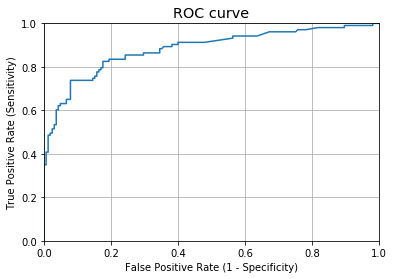

In [50]:
fpr, tpr, thresholds = roc_curve(val_y, predict_proba_grid[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [51]:
%matplotlib inline
# %matplotlib

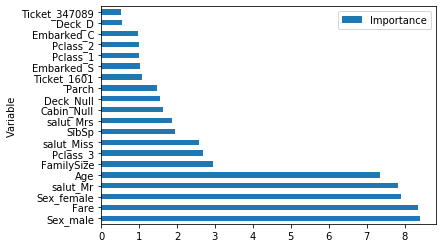

In [52]:
df_random_forest_feature_importance.head(20).plot(kind='barh', y="Importance", x="Variable")